# Take Home End-Semester Exam: Mobile Robotics - M21

**Name**: Avneesh Mishra <br>
**Roll No**: `2021701032`


In [1]:
# Import everything
import open3d as o3d
import numpy as np
import util
from matplotlib import pyplot as plt
# Other imports
import sympy as sp
from IPython.display import display

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


---

## Optimization through LM

**1. Optimization**: You are given the function:  exp(-a * x) * sin(x) + b. Implement Levenberg Marquadt using numpy and solve for the parameters of the above function. Optimize for the following parameters: a=2, b = 1. Do this for 50 observations that lie between 1 and 20. Plot the loss values over time and data fit curves. Ensure that your initial estimates are not very close to the final parameters. Write down the jacobian formula in the notebook. **\[3 points\]**

### Theory

The function given is

$$ y(x; a, b) = \textup{e}^{-ax} \sin(x) + b $$


**Jacobian Formulation**: Partial derivatives of $y$ with respect to $a$ and $b$. These are given by

$$
\frac{\partial y}{\partial a} = -x \; \textup{e}^{-ax} \sin(x)
\qquad \qquad \qquad \qquad
\frac{\partial y}{\partial b} = 1
$$

The jacobian is given by

$$ \mathbf{J}_y = \left [ \frac{\partial y}{\partial a} \quad \frac{\partial y}{\partial b} \right ] $$


In [2]:
# Theoretically verify the Jacobian using Sympy
x, a, b = sp.symbols("x, a, b")
eq_y = sp.exp(-a*x)*sp.sin(x) + b
dy_da = eq_y.diff(a)
dy_db = eq_y.diff(b)
print("Partial derivative of y w.r.t. a is ")
display(dy_da)
print("Partial derivative of y w.r.t. b is ")
display(dy_db)

Partial derivative of y w.r.t. a is 


-x*exp(-a*x)*sin(x)

Partial derivative of y w.r.t. b is 


1

**Loss Formulation**: We need something to say how good our estimates of $a$ and $b$ are

From a given set of observations $\left \{ (x_i, y_i) \right \}$ (sampled from the original / underlying curve), and a known (current) estimate of parameters $(\hat{a}_k, \hat{b}_k)$, we can calculate the new error (deviation of the estimated model from the original observations as)

$$ L_k = \frac{1}{2} \sum_i \left ( y(x_i; \hat{a}_k, \hat{b}_k ) - y_i \right )^2 = \frac{1}{2} \mathbf{r}_k^\top \mathbf{r}_k $$

Where $\mathbf{r}_k$, the residual vector, is given by

$$ \mathbf{r}_k = y(x_{\textup{obs}}; \hat{a}_k, \hat{b}_k ) - y_{\textup{obs}} $$

**Minimizing Loss**: Finding the best parameters $a$ and $b$ that'll reduce the $L$ value significantly.

For a gradient descent step, we'd get the new parameter estimates $\mathbf{\hat{h}}_{k+1} = [\hat{a}_{k+1} \;\; \hat{b}_{k+1}]^\top$ as

$$
\mathbf{\hat{h}}_{k+1} = \mathbf{\hat{h}}_{k} + \delta \mathbf{\hat{h}} = \mathbf{\hat{h}}_{k} - \alpha \; \mathbf{J}_y^\top \; \mathbf{r}_k
$$

For a Levenberg Marquadt step, we take a middle ground between gauss-newton and gradient descent. We get the new parameter estimates as

$$
\delta \mathbf{\hat{h}} = - \left ( \mathbf{J}_y^\top \mathbf{J}_y + \lambda \mathbf{I} \right )^{-1} \mathbf{J}_y^\top \mathbf{r}_k
\Rightarrow \mathbf{\hat{h}}_{k+1} = \mathbf{\hat{h}}_{k} - \left ( \mathbf{J}_y^\top \mathbf{J}_y + \lambda \mathbf{I} \right )^{-1} \mathbf{J}_y^\top \mathbf{r}_k
$$

We set $\lambda$ to a constant here.


### Implementation

Implementing the LM algorithm (actually Levenberg Method) in this section.

In [3]:
# Default values
a_original, b_original = 2, 1
# Function
def y_x_ab(x, a = a_original, b = b_original):
    return np.exp(-a * x) * np.sin(x) + b
# The jacobians
def jac_y(x, a, b):
    N = len(x)
    dy_da = -x * np.exp(-a*x) * np.sin(x)
    dy_da = dy_da.reshape(N, 1).astype(float)
    dy_db = np.ones((N, 1), float)
    jac = np.hstack((dy_da, dy_db))
    return jac
# The loss values
def calc_loss(y_pred, y_true):
    return 0.5*np.sum((y_pred - y_true)**2)

In [4]:
# Generate data
x_vals = np.linspace(1, 20, 50)
y_vals = y_x_ab(x_vals)
# Initial estimates
a_k, b_k = 3.5, 5
lm_lambda = 0.07 # Lambda value for LM method (fixed)
lm_steps = 32   # Number of steps for LM method
# Log everything
est_hist = [[a_k, b_k]] # Estimates
loss_hist = [calc_loss(y_x_ab(x_vals, a_k, b_k), y_vals)]   # Loss

In [5]:
a_i, b_i = a_k, b_k
# Main optimization
for i in range(lm_steps):
    # Calculate Jacobian
    J_y = jac_y(x_vals, a_k, b_k)
    # Residuals
    res = y_x_ab(x_vals, a_k, b_k) - y_vals
    # Change in vals
    d_h = -np.linalg.inv(J_y.T @ J_y + \
        lm_lambda * np.eye(2)) @ J_y.T @ res
    # New values
    a_k = a_k + d_h[0]
    b_k = b_k + d_h[1]
    # Log everything
    est_hist.append([a_k, b_k])
    loss_hist.append(calc_loss(y_x_ab(x_vals, a_k, b_k), y_vals))

In [6]:
print(f"Original values of a, b = {a_original}, {b_original}")
print(f"Initial values of a, b = {a_i:.4f}, {b_i:.4f}")
print(f"Final values of a, b = {a_k:.4f}, {b_k:.4f}")
print(f"Final loss is: {loss_hist[-1]:.6f}")

Original values of a, b = 2, 1
Initial values of a, b = 3.5000, 5.0000
Final values of a, b = 2.0428, 1.0002
Final loss is: 0.000019


### Visualize the result

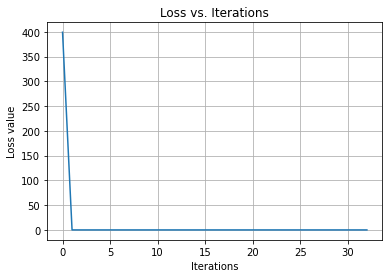

In [7]:
# Loss Value (absolute)
plt.figure()
plt.title("Loss vs. Iterations")
plt.plot(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("Loss value")
plt.grid()
plt.show()

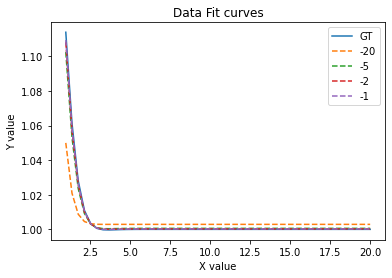

In [8]:
# Curves
viz_cs = [-20, -5, -2, -1]  # Sequences to visualize
# Plot everything
plt.figure()
plt.title("Data Fit curves")
plt.plot(x_vals, y_vals, '-', label="GT")
for i, (a, b) in enumerate(np.array(est_hist)[viz_cs]):
    y_v = y_x_ab(x_vals, a, b)
    plt.plot(x_vals, y_v, '--', label=f"{viz_cs[i]}")
plt.xlabel("X value")
plt.ylabel("Y value")
plt.legend()
plt.show()

The plots in 'true' scale domain may be useless (nothing can be made out of it). Let's plot and show the results in the `log` scale. We'll plot only the absolute value of the function $y$. Fortunately, no value of $x$ is a multiple of $\pi$ (because `linspace` won't give us irrational numbers) we can therefore successfully plot them.

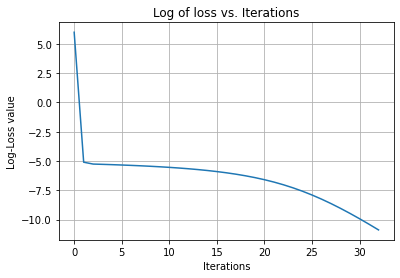

In [9]:
# Log-loss values
plt.figure()
plt.title("Log of loss vs. Iterations")
plt.plot(np.log(loss_hist)) # Can go to -ve for loss << 1
plt.xlabel("Iterations")
plt.ylabel("Log-Loss value")
plt.grid()
plt.show()

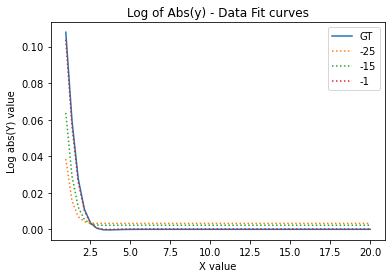

In [10]:
# Log-value plots
viz_cs = [-25, -15, -1]  # Sequences to visualize
# Plot everything
plt.figure()
plt.title("Log of Abs(y) - Data Fit curves")
plt.plot(x_vals, np.log(np.abs(y_vals)), '-', label="GT")
for i, (a, b) in enumerate(np.array(est_hist)[viz_cs]):
    y_v = y_x_ab(x_vals, a, b)
    plt.plot(x_vals, np.log(np.abs(y_v)), ':', label=f"{viz_cs[i]}")
plt.xlabel("X value")
plt.ylabel("Log abs(Y) value")
plt.legend()
plt.show()

This seems better (more well separated, as well as better descending in loss). We can observe the exponential term (value for $a$) also updating accordingly. The final results are as follows.

In [11]:
print(f"Original values of a, b = {a_original}, {b_original}")
print(f"Final values of a, b = {a_k:.4f}, {b_k:.4f}")

Original values of a, b = 2, 1
Final values of a, b = 2.0428, 1.0002


In [12]:
print(f"Final loss is: {loss_hist[-1]:.6f}")

Final loss is: 0.000019


---

## Linear Least Square

**2. Linear least square**: You are given a bin file from the Kitti raw sequence. Estimate the ground plane from the given bin file. After estimating the ground plane, visualize this in open3d by drawing 200-300 points on the ground with a different color on top of the plot obtained from the LiDAR scan. Use RANSAC to estimate the ground plane. Will this work without RANSAC? Why or Why not? Write down the equation of the ground plane obtained and also mention the parameters used for doing RANSAC  **\[6 points\]**



Expected result is displayed here:

![output](./data/groundplane.png)

In [13]:
def read_bin_file(file_name):
    '''
    Read the bin file
    '''
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3]                # exclude reflectance values, becomes [X Y Z]
    points = points[1::5,:]              # remove every 5th point for display speed (optional)
    return points

In [14]:
filename = "./data/000013.bin"
points = read_bin_file(filename)
# A coordinate frame (just for reference)
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, 
    origin=[0, 0, 0])
# Function used to visualize point clouds, takes a list of 3 x N numpy array as input and plots
util.visualize_pointclouds([points.T], cf)

### Ignore: Lazy Solution

A very simple, but extremely lazy solution can be found using mode of the Z values. This is because the axis are (nearly) aligned with the plane, so the most frequent Z value will be the plane. Check out [statistics.mode](https://docs.python.org/3/library/statistics.html#statistics.mode) for this.

This does **not** involve RANSAC or _any_ optimization, but will fail _terribly_ if the XY plane isn't truly aligned with the ground plane. We'll use this as a validation, and this can be ignored for most of the work after the following result.

In [15]:
import statistics
# Get the Z values
z_v = points[:, 2]
# Get the mode (plane: Z depth)
pz_depth = statistics.mode(z_v)
print(f"The ground plane is probably at: Z = {pz_depth}")

The ground plane is probably at: Z = -1.3147779703140259


However, if there are significant outliers (say the point cloud of a wall in front), then this method can fail. We shall move to least squares solution (using RANSAC)

### Fitting a plane using Least Squares

**Model of plane**: We assume that the ground plane can be represented as $z = ax + by + c$ (that is, the Z axis is not in the ground plane as a part of it). We're given a set of $\{(x_i, y_i), z_i\}$ points, we need to find $a, b, c$ parameters.

Theoretically, 3 points are enough to fit a plane. However, having a little more points can give a better estimate. We'll use 5 points here. So we fit a plane through five points.

**Direct Solution**

A direct solution can be found using the form $\mathbf{z} = \mathbf{X} \mathbf{w}$ where $\mathbf{X} = \left [ \mathbf{x} \;\; \mathbf{y} \;\; \mathbf{1} \right ]_{5, 3}$ is formed by the data points $\{(x_i, y_i)\}$, $\mathbf{w} = [a \;\; b \;\; c]_{3, 1}$ is the parameter vector, and $\mathbf{z}_{5, 3}$ is formed by the data points $z_i$. We get this solution using the pseudo-inverse as described below

$$
\mathbf{Xw} = \mathbf{z} \Rightarrow \mathbf{X^\top Xw} = \mathbf{X^\top z} \Rightarrow \mathbf{w} = \left ( \mathbf{X^\top X} \right )^{-1} \mathbf{X^\top z}
$$

This is implemented in the function `fit_plane_one_shot`

In [16]:
def fit_plane_one_shot(x, y, z):
    X = np.vstack((x, y, np.ones_like(x))).T
    W = np.linalg.inv(X.T @ X) @ X.T @ z
    a, b, c = W
    return a, b, c

**Least Squares solution**

We define the objective to be

$$
L = \frac{1}{2} \sum_{i=1}^{N} \left( \hat{z}_i - z_i \right )^2 \qquad
\textup{where} \;\; \hat{z}_i = ax_i + by_i + c
$$

It is clear that for $\mathbf{w} = [a \;\; b \;\; c]_{3, 1}$, the jacobian will be

$$
\frac{\partial L}{\partial \mathbf{w}} = \mathbf{X^\top r} \qquad
\textup{where} \;\; \mathbf{r}_{N, 1} = \mathbf{\hat{z}}_{N, 1} - \mathbf{z}_{N, 1}
$$

We can either use gradient descent, or LM (as we did earlier)

- _Gradient Descent_ will give the update rule. This is implemented in `fit_plane_gd`

    $$ \delta \mathbf{w} = -\alpha \mathbf{X^\top r} $$

- _LM_ will give the update rule. This is implemented in `fit_plane_lm`

    $$ \delta \mathbf{w} = - \left ( \mathbf{X^\top X} + \lambda \mathbf{I} \right )^{-1} \mathbf{X^\top r} $$



In [17]:
# Fit plane using Gradient Descent
def fit_plane_gd(x, y, z, N = 25, lr = 4e-3):
    def z_xy(x, y, a, b, c):
        return a*x+b*y+c
    X = np.vstack((x, y, np.ones_like(x))).T
    w_init = np.random.rand(3)
    w = w_init
    for _ in range(N):
        res = z_xy(x, y, *w) - z    # Residuals
        dW = (-lr) * X.T @ res
        w += dW
    a, b, c = w
    return a, b, c

# Fit plane using Levenberg Marquadt
def fit_plane_lm(x, y, z, N = 10, lm_lb = 0.5):
    def z_xy(x, y, a, b, c):
        return a*x+b*y+c
    X = np.vstack((x, y, np.ones_like(x))).T
    w_init = np.random.rand(3)
    w = w_init
    for _ in range(N):
        res = z_xy(x, y, *w) - z    # Residuals
        dW = -np.linalg.inv(X.T @ X + lm_lb * np.eye(3)) @ X.T @ res
        w += dW
    a, b, c = w
    return a, b, c

Because of speed, convergence and stability, we'll use `fit_plane_one_shot` or `fit_plane_lm`


In [18]:
# Testing the above methods
x = np.random.rand(5) * 10
y = np.random.rand(5) * 10
# z = ax + by + c, estimate a, b, c; given {(x, y), z}
_a, _b, _c = -1.32, 3.4, -5.27
def z_xy(x, y, a = _a, b = _b, c = _c):
    return a*x+b*y+c
z_true = z_xy(x, y)
print(f"One Shot: {fit_plane_one_shot(x, y, z_true)}")
print(f"LM: {fit_plane_lm(x, y, z_true)}")

One Shot: (-1.320000000000002, 3.400000000000004, -5.270000000000002)
LM: (-1.3242965509369844, 3.398622669053574, -5.2412578619101735)


### RANSAC: Random Sample Consensus

We have many points in the point cloud. For a decided number of times, we'll randomly pick 5 points, fit a plane through it, check how many points conform to the plane (Z disparity is within a threshold), and add it to a list of candidates we're tracking (along with its score of the number of conforming points).

In the end (after a decided number of iterations), the plane with the most number of conforming points is chosen as the result.

More details on the solution after visualizing the result.


The parameters used for RANSAC are described below

- Number of runs `N_r`: Number of times to run the RANSAC process. We'll have a 300 runs.
- Number of samples `N_s`: The number of samples used in each run to find the plane. This is 5 in our case, as we're using 5 points in each run to find the equation of the place.
- Inlier threshold `dz_thresh`: The threshold for absolute difference in Z values of points (to be considered as inliers). Let the points be in a 10 cm threshold (or `0.1` m).
- Task function `find_plane`: This function takes a set of points $\mathbf{x}$, $\mathbf{y}$ and $\mathbf{z}$ and returns $a, b, c$ (the parameters of the plane passing through the points). The plane is expressed in the form $z = ax + by + c$. This is a wrapper for `fit_plane_one_shot` or `fit_plane_lm`

In [19]:
# Parameters
N_r = 300
N_s = 5
dz_thresh = 0.1
# Use the one shot solution for plane
find_plane = lambda x, y, z: fit_plane_lm(x, y, z)

In [20]:
# --- RANSAC Implementation ---

# Function: Get z for x and y
def z_xy(x, y, a, b, c):
    return a*x+b*y+c

# Store results
pl_vals = []    # Plane values
ncps = []   # No. of points conforning
for i in range(N_r):
    # Sample N_s points randomly
    si = np.random.randint(0, points.shape[0], N_s)
    x = points[si, 0]
    y = points[si, 1]
    z = points[si, 2]
    # Main task: Fit the plane
    a, b, c = find_plane(x, y, z)
    # Log it
    pl_vals.append([a, b, c])
    # Number of points conforming
    zhat = z_xy(points[:, 0], points[:, 1], a, b, c)
    dza = np.abs(zhat - points[:, 2])   # Abs. diff. in Z vals
    ncps.append(np.sum(dza < dz_thresh))    # Number of inliers
# Some adjustments for the end
pl_vals = np.array(pl_vals)
ncps = np.array(ncps)
# Best values of the a, b, c - points that have maximum inliers
a, b, c = pl_vals[np.argmax(ncps)]
print(f"Estimated plane parameters (a, b, c): "
    f"{a:.3f}, {b:.3}, {c:.3}")

Estimated plane parameters (a, b, c): 0.014, 0.0273, -1.71


This isn't too far from the expected solution (maybe the lazy solution was wrong). Let's see how it looks with the point cloud

### Visualizing the resulting plane

The parameters $a, b, c$ are obtained through RANSAC earlier. In this section, the result is shown

In [21]:
nx, ny = 100, 100
# X axis ticks
xt = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), nx)
# Y axis ticks
yt = np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), ny)
# Grid - XY plane
xyg = np.array(np.meshgrid(xt, yt)).T.reshape(-1, 2)
# Get Z values
zvs = z_xy(xyg[:, 0], xyg[:, 1], a, b, c)
# Plane points
plane_pts = np.hstack((xyg, zvs.reshape(-1, 1)))

In [22]:
# Show them in o3d with the point cloud
util.visualize_pointclouds([points.T, plane_pts.T], cf)

The resulting plane obtained looks fairly obvious and good. It's shown below

<img src="./figures/res_plane.png" width=450 alt="Ground plane" />

<img src="./figures/res_plane2.png" width=450 alt="Ground plane from another view" />

Note how the orange dots appear well aligned on the blue dots.

### Will this work without RANSAC

It is highly unlikely that we will get such a good result without RANSAC. We can see that through RANSAC, we get a plane that almost fits the true ground plane (estimated by the region around the center aligning with the orange dots). There are greater chances that (through RANSAC) when we sample a small number of points, they lie on the plane, _than_ the changes of the entire scene uniformly lying on a plane and giving us that. However, it really depends on the scene.

Note that for RANSAC, it's not the majority that has to concur, it's only that the most number of samples that concur decide the result. There could be few points on the ground, but if the maximum that concur come from the estimates that are the true ground, then the ground will be selected.

If we do not use RANSAC, we could find the best fit by pushing the entire point cloud through the `fit_plane_*` functions (but this could be very clunky, there are too many points). The result is shown in the cells below.

In [23]:
print(f"RANSC: {a}, {b}, {c}")
aos, bos, cos = fit_plane_one_shot(points[:, 0], points[:, 1],
    points[:, 2])
print(f"One Shot: {aos}, {bos}, {cos}")
alm, blm, clm = fit_plane_lm(points[:, 0], points[:, 1], 
    points[:, 2])
print(f"LM: {alm}, {blm}, {clm}")

RANSC: 0.014496642039066268, 0.027300785373603878, -1.7111932801977787
One Shot: 0.012147373519837856, 0.005404871888458729, -1.4274954795837402
LM: 0.012147378957080672, 0.005404870614909125, -1.4274955354924441


In [24]:
# Get Z values
zvsos = z_xy(xyg[:, 0], xyg[:, 1], aos, bos, cos)
zvslm = z_xy(xyg[:, 0], xyg[:, 1], alm, blm, clm)
# Plane points
planeos_pts = np.hstack((xyg, zvsos.reshape(-1, 1)))
planelm_pts = np.hstack((xyg, zvslm.reshape(-1, 1)))
# Visualize it
util.visualize_pointclouds([points.T, plane_pts.T, planeos_pts.T, 
    planelm_pts.T], cf)

We got an estimate, but the other points in the scene raised the level of ground.

<img src="./figures/res_plane_others.png" width=450 alt="Ground plane through others too" />

Note how the orange points still align with the region around the ground better than the red (and green) points, which are more in air (these are the direct one-shot and LM solutions). The _lazy_ solution also gave us the same error (note that we took the _mode_ there).

Hence, for this problem, **RANSAC gave better estimates**.


The equation of the plane is

$$ z = a x + b y + c $$

Where $a = 0.02570133019191215$, $b = 0.029228050710190592$ and $c = -1.7198900700311772$ (the RANSAC solution).

The model parameters for RANSAC was described in the section that introduced RANSAC.

In [ ]:
# Cell for rough work!